In [ ]:
# Thiết lập môi trường torch
!pip3 install torch torchvision torchaudio

In [ ]:
# Sử dụng Wandb - Quản lý thử nghiệm
!pip install wandb

In [ ]:
import wandb
api_key='ce1ed98a6adb35a58930377a328c4e1cc6f9651c' # Mỗi người sẽ có mã khác nhau
wandb.login(key=api_key)

wandb: Currently logged in as: 21130449 (21130449nguyenkhainam). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Cài đặt torch summary
!pip install torch-summary

In [ ]:
# Thiết lập Roboflow - Xử lý thị giác và cung cấp tập dữ liệu
!pip install roboflow

In [ ]:
# Sử dụng bộ dữ liệu Roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="yaFqyKn0GZYzFVwXFQgS") # Mỗi người sẽ có mã khác nhau
project = rf.workspace("tbitak-bilgem").project("animalclassification-gktyx")
dataset = project.version(1).download("folder")

# Kiểm tra thư mục tải về
print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: /content/AnimalClassification-1


In [ ]:
!pip install Path

  Using cached path-16.14.0-py3-none-any.whl (25 kB)


In [ ]:
# Thiết lập đường dẫn tới data cho tiện việc sử dụng
from pathlib import Path
image_path = Path(dataset.location)
train_path = image_path.joinpath("train")
test_path = image_path.joinpath("test")

Random image path: /content/AnimalClassification-1/valid/panda/03b7ec608a_jpg.rf.c7ae38432a1f594603fd0d12dc30b6b0.jpg
Image class: panda
Image height: 640
Image width: 640


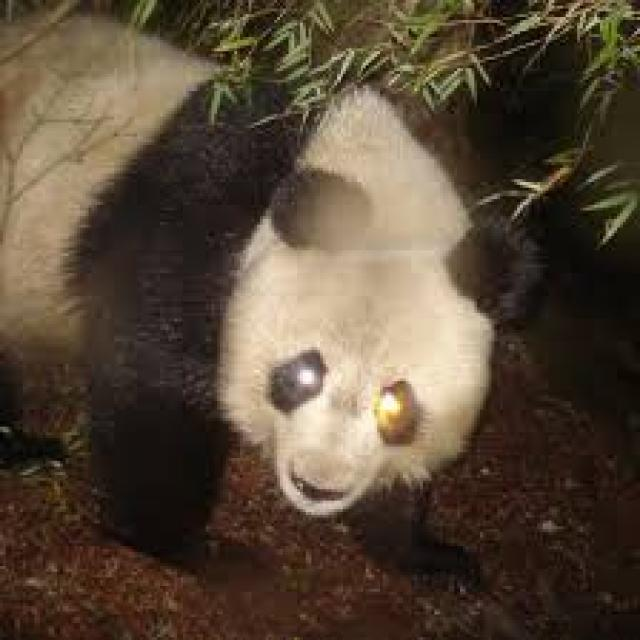

In [ ]:
# Kiểm tra thử dữ liệu đã lấy thành công chưa
import random
from PIL import Image
image_path_list = list(image_path.rglob("*.jpg"))
random_img_path=random.choice(image_path_list)
img_class=random_img_path.parent.stem
img=Image.open(random_img_path)
print(f"Random image path: {random_img_path}")
print(f"Image class: {img_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [ ]:
# Tên của các lớp dữ liệu
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

target_dir=train_path
print(f"Target dir: {target_dir}")
class_name_found=sorted([entry.name for entry in list(os.scandir(image_path/"train"))])
print(class_name_found)
print(f'Total: {len(class_name_found)}')

Target dir: /content/AnimalClassification-1/train
['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']
Total: 90


In [ ]:
# Xử lý dữ liệu
IMG_SIZE=224
from torchvision.transforms import transforms
manual_transform=transforms.Compose(
    [transforms.Resize(size=(IMG_SIZE,IMG_SIZE)),
     transforms.ToTensor()]
)
manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

# Lý do lựa chọn 224x224 làm kích thước đầu vào
Trong bài báo tại bảng 3, tác giả có để cập đến Trainning resolution is 224, ở đây chúng ta hiểu ảnh đầu vào có thể hiểu kích thước hình ảnh đầu vào có dạng 224x224x3, đó cũng chính là do sử dụng 224x224 làm kích thước đầu vào. Ngoài ra nhóm tác giả cũng đề cập tới việc sử dụng batch_size cho dataloader là 4096, nhưng do giới hạn của phần cứng nên trong bài này chúng em sẽ sử dụng batch_size=32.

In [ ]:
# Tạo Datasets và Dataloaders
import os
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

NUM_WORKERS=os.cpu_count()
def create_dataloader(train_dir:str,test_dir:str,transform:transforms.Compose,batch_size:int,num_workers:int=NUM_WORKERS):
    train_data=datasets.ImageFolder(train_dir,transform=transform)
    test_data=datasets.ImageFolder(test_dir,transform)

    train_dataloader=DataLoader(dataset=train_data,num_workers=num_workers,batch_size=batch_size,shuffle=True,pin_memory=True)
    test_dataloader=DataLoader(dataset=test_data,batch_size=batch_size,pin_memory=True,num_workers=num_workers,shuffle=False)
    class_name=train_data.classes
    return train_dataloader,test_dataloader,class_name

BATCH_SIZE=32
train_dataloaders,test_dataloader,class_name=create_dataloader(train_dir=train_path,test_dir=test_path,transform=manual_transform,batch_size=BATCH_SIZE,num_workers=0)

In [ ]:
# Kiểm tra
image_batch, label_batch=next(iter(train_dataloaders))
image, label=image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(55))

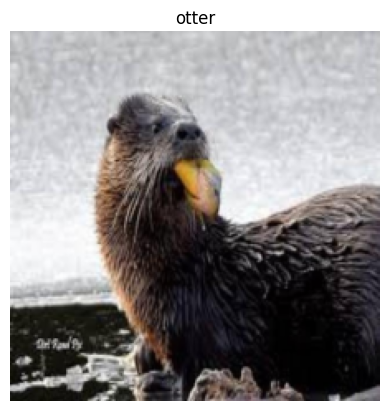

In [ ]:
# Kiểm tra
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))
plt.title(class_name[label])
plt.axis(False);

In [ ]:
# Công thức 1: Tách ảnh ban đầu thành các miếng (patches), tạo các lớp, vị trí nhúng,...

# 1. Công thức
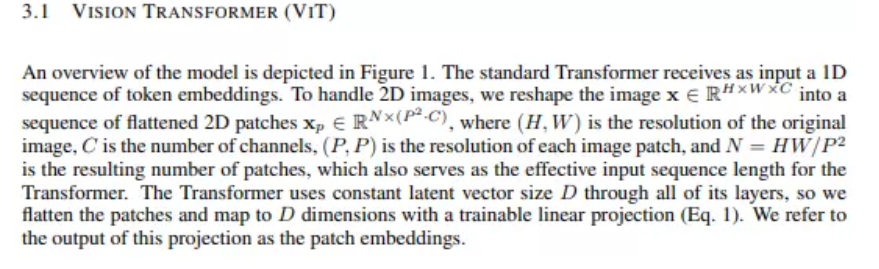

In [ ]:
# 2. Thử tính toán đầu vào và đầu ra của Patch Embedding
# Công thức: N=HW/P^2 => N=(224∗224)/16^2 = 196
height=224 #Chiều cao của ảnh
width=224 #Chiều rộng của ảnh
color_channels=3 #Kênh màu
patch_size=16 #Patch size

number_of_patches=int((height*width)/patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [ ]:
# kích thước một chuỗi các flatten 2D patches.
# Đầu vào: Hình ảnh bắt đầu với 2D có kích thước H x W x C
# Đầu ra: Hình ảnh chuyển đổi thành flatten 2D patches với kích thước N x (P ^ 2 x C)
embedding_layer_input_shape=(height,width,color_channels)
embedding_layer_output_shape=(number_of_patches,patch_size**2*color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


In [ ]:
# 3. Biến hình ảnh các patches

(-0.5, 223.5, 223.5, -0.5)

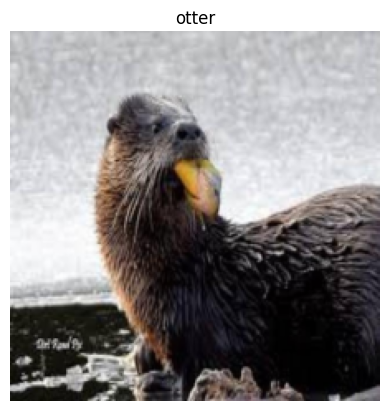

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_name[label])
plt.axis(False)

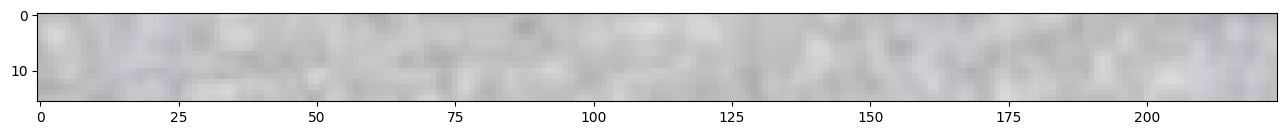

In [ ]:
image_permuted=image.permute(1,2,0)
patch_size=16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


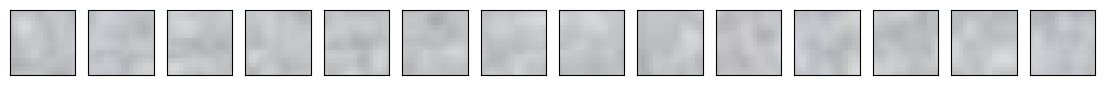

In [ ]:
img_size=224
patch_size=16
number_patches=img_size/patch_size
assert img_size%patch_size == 0,"Image size must be divisible by patch size"
print(f"Number of patches per row: {number_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")
fig, axs=plt.subplots(nrows=1,ncols=img_size//patch_size,sharex=True, sharey=True, figsize=(number_patches, number_patches))
for i,patch in enumerate(range(0,img_size,patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


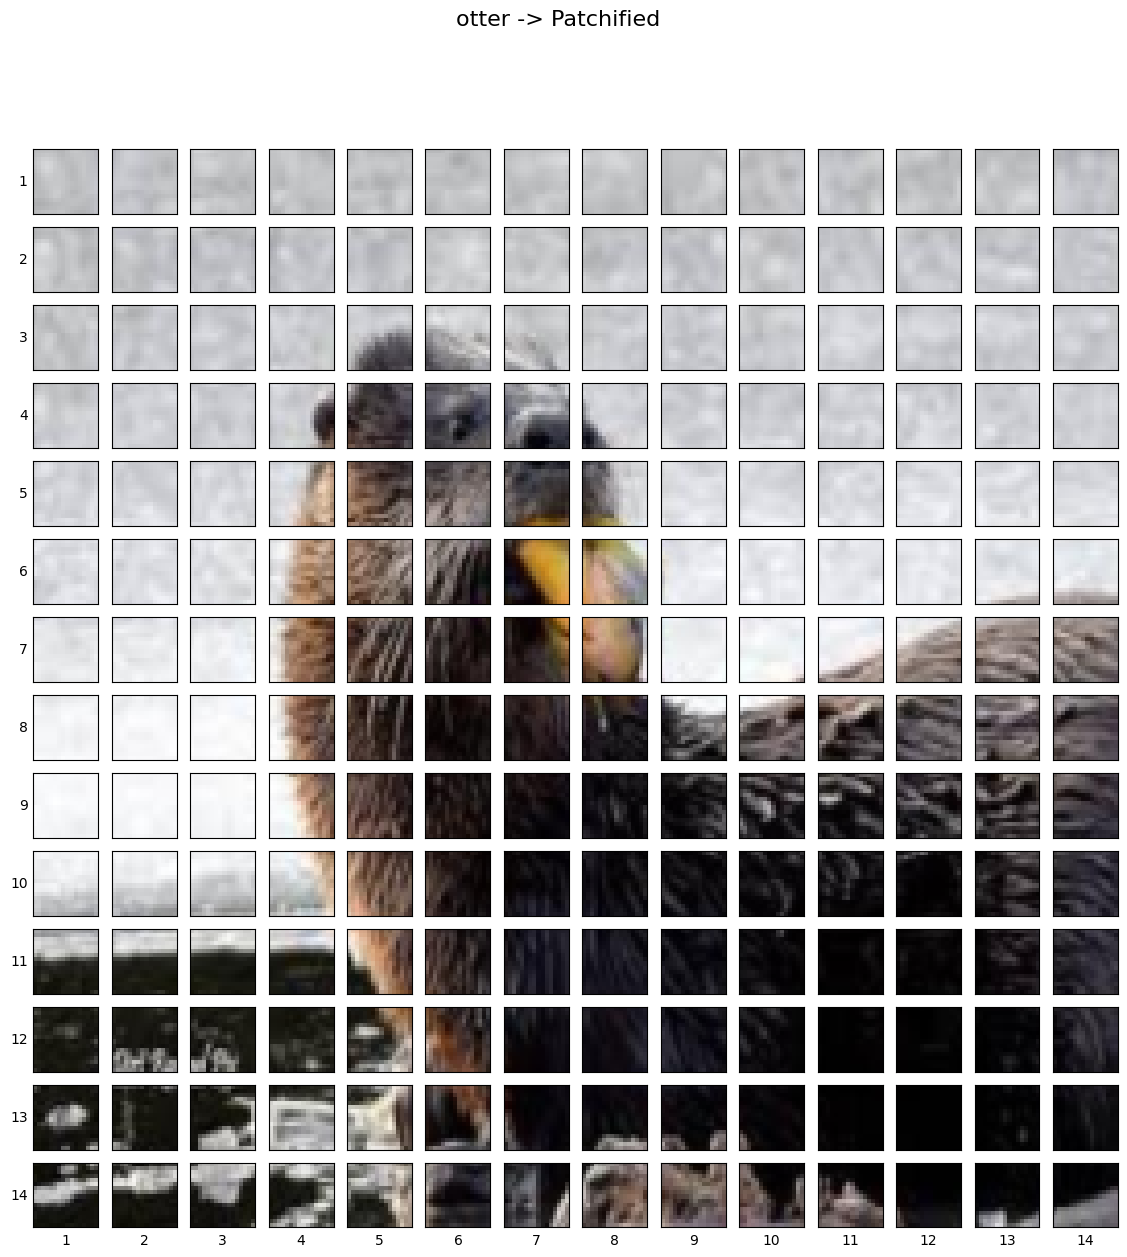

In [ ]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_name[label]} -> Patchified", fontsize=16)
plt.show()

In [ ]:
# 4. Tạo các patches image
from torch import nn
patch_size=16
conv2d=nn.Conv2d(in_channels=3,out_channels=768,kernel_size=patch_size,stride=patch_size,padding=0)

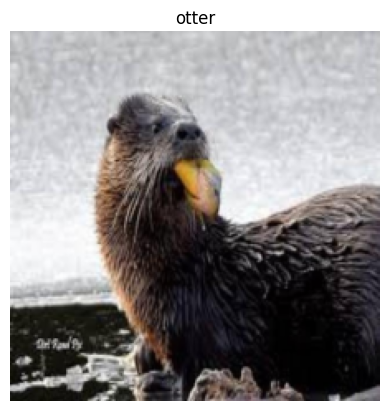

In [ ]:
# Kiểm tra lại ảnh khi dùng conv2d
plt.imshow(image.permute(1, 2,0))
plt.title(class_name[label])
plt.axis(False);

In [ ]:
image_out_of_conv= conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [390, 450, 654, 342, 597]


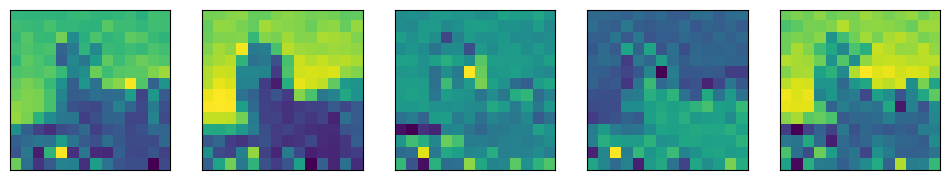

In [ ]:
# Thử hiển thị Feature Maps
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# 5. Flatten cho các patches image
# Đầu ra mà chúng ta mong muốn là : (196, 768) -> (number of patches, embedding dimension) hay N x (P ^ 2 x C)
# Không làm phẳng toàn bộ tensor mà chỉ làm phẳng phần đặc biệt chính là spatial dimensions of the feature map
flatten=nn.Flatten(start_dim=2 # flatten feature_map_height (dimension 2)
                   ,end_dim=3) #flatten feature map_width(dimension 3)


Original image shape: torch.Size([3, 224, 224])
Image after turning into features map: torch.Size([1, 768, 14, 14]) 
Flatten image features map shape: torch.Size([1, 768, 196])


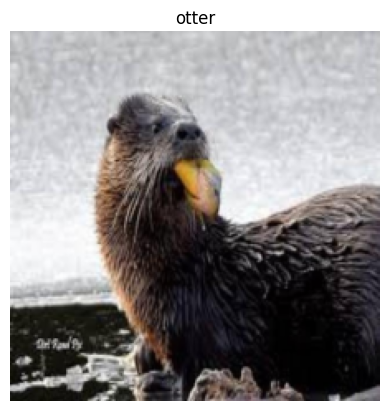

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_name[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")
#2. Turn image into features maps
image_out_of_conv=conv2d(image.unsqueeze(0)) #add batch dimensions to avoid shape errors
print(f"Image after turning into features map: {image_out_of_conv.shape} ")
#3. Flatten the features map
image_out_of_conv_flattend=flatten(image_out_of_conv)
print(f"Flatten image features map shape: {image_out_of_conv_flattend.shape}")

In [ ]:
# Hình dạng bị ngược với hình dạng mà chúng ta mong muốn
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattend.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

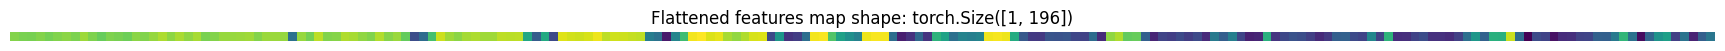

In [ ]:
single_flattened_feature_map=image_out_of_conv_flattened_reshaped[ :,:, 0] # index: (batch_size, number_of_patches, embedding_dimension)

plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened features map shape: {single_flattened_feature_map.shape}')
plt.axis(False)

In [ ]:
# 6. Chuyển ViT Patch Embedding vào module Pytorch.
# 1. Tạo lớp cho tiện sử dụng
class PatchEmbedding(nn.Module):
    '''Turn a 2D input into 1D sequence learnable embedding vector
    Args:
        - in_channels(int): Number of color channels for the input images. Defaults to 3
        - Patch_size (int): Size of patches to convert input image into. Defaults to 16
        - embedding_dim(int): Size of embedding to turn image. Default to 768
    '''
    #2. Khởi tạo các biến cần thiết
    def __init__(self,in_channel:int=3,patch_size:int=16,embedding_dim:int=768):
        super().__init__()
        #3. Tạo các layer
        self.patcher=nn.Conv2d(in_channels=in_channel,padding=0,stride=patch_size,out_channels=embedding_dim,kernel_size=patch_size)
        #4. Tạo flatten
        self.flatten=nn.Flatten(start_dim=2,end_dim=3)
    def forward(self,x):
        image_resolution=x.shape[-1]
        assert image_resolution%patch_size==0, f"Input image size must be divisible by patch size, image shape:{image_resolution}, patch size: {patch_size}"

        #Perform the forward pass
        x_patched=self.patcher(x)
        x_flattend=self.flatten(x_patched)
        return x_flattend.permute(0,2,1) # Adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


In [ ]:
# Kiểm tra mã vừa tạo
def set_seed(seed:int=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

set_seed()
patchify=PatchEmbedding(in_channel=3,patch_size=16,embedding_dim=768)
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image=patchify(image.unsqueeze(0)) #Add an extra batch dimension
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
# Cài thêm torchinfo
!pip install torchinfo

In [ ]:
# Tổng quan tham số
# Ngẫu nhiên
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)

from torchinfo import summary
summary(PatchEmbedding(),
input_size=random_input_image,
col_names=["input_size", "output_size", "num_params", "trainable"],
col_width=20,
row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [ ]:
# 7. Tạo Class Token Embedding
# Xem lại chuỗi các Embedding và kích thước của nó (tạo trong 6.)
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.8140,  0.1974, -0.2126,  ...,  0.5993, -0.3500,  0.2722],
         [-0.8197,  0.2055, -0.2520,  ...,  0.6362, -0.3573,  0.3184],
         [-0.7745,  0.2199, -0.2287,  ...,  0.6216, -0.3877,  0.2756],
         ...,
         [-0.0331, -0.0061, -0.0803,  ...,  0.0438, -0.0020,  0.0267],
         [-0.1644,  0.0097, -0.2763,  ...,  0.1945,  0.0026,  0.1412],
         [-0.0796,  0.0480, -0.3384,  ...,  0.3031, -0.0050,  0.0493]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# chuẩn bị Embedding có thể học được vào chuỗi các Patch Embedding
# ạo ra một Embedding có thể học được trong shape của embedding_dimension (D) sau đó cộng chúng vào chiều number_of_patches
batch_size=patch_embedded_image.shape[0]
embedding_dimension=patch_embedded_image.shape[-1]

# dùng torch.ones, mục đích là để có thể biểu diễn, trong thực tế có thể thay đổi thành torch.randn() để khai thác hết súc mạng của random.
class_token=nn.Parameter(torch.ones(batch_size,1,embedding_dimension),# [batch_size, number_of_tokens, embedding_dimension]
                        requires_grad=True)

print(class_token[:,:,10])
print(f"Shape of classtoken: {class_token.shape}->[batch_size, number_of_tokens, embedding_dimension]")

tensor([[1.]], grad_fn=<SelectBackward0>)
Shape of classtoken: torch.Size([1, 1, 768])->[batch_size, number_of_tokens, embedding_dimension]


In [ ]:
# Gộp lại
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8140,  0.1974, -0.2126,  ...,  0.5993, -0.3500,  0.2722],
         [-0.8197,  0.2055, -0.2520,  ...,  0.6362, -0.3573,  0.3184],
         ...,
         [-0.0331, -0.0061, -0.0803,  ...,  0.0438, -0.0020,  0.0267],
         [-0.1644,  0.0097, -0.2763,  ...,  0.1945,  0.0026,  0.1412],
         [-0.0796,  0.0480, -0.3384,  ...,  0.3031, -0.0050,  0.0493]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# Tổng quan quá trình
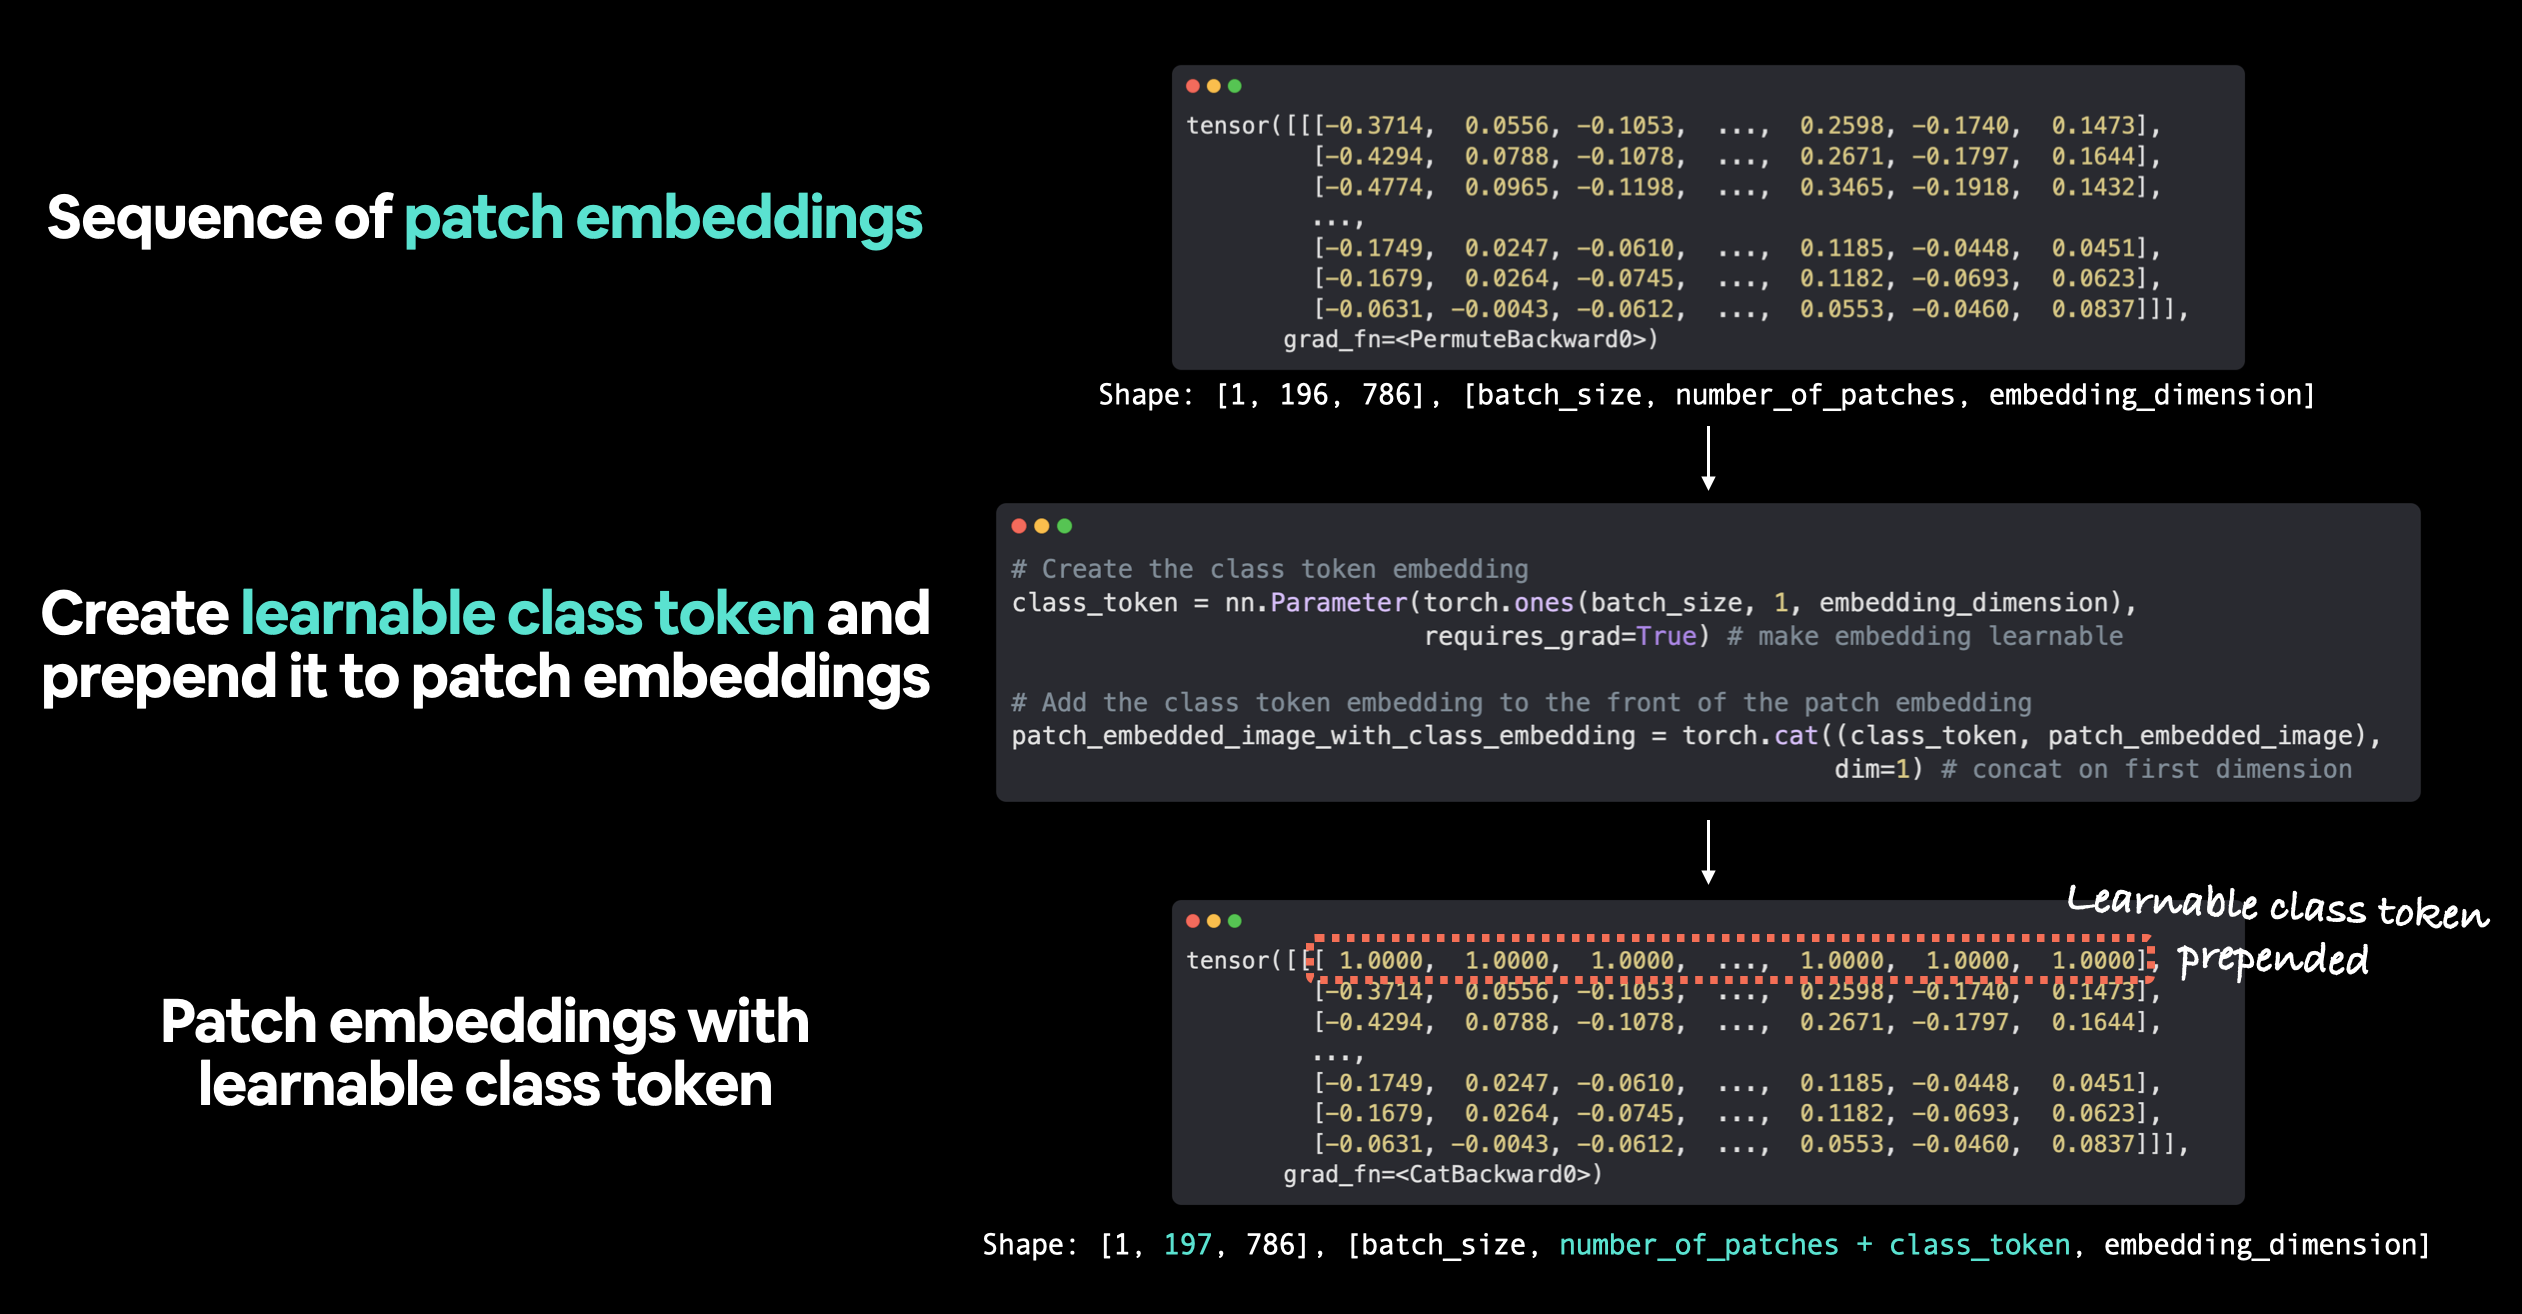

In [ ]:
# 8. Tạo Position Embedding
# Calculate N ( number of patches)
number_of_patches=int((height*width)/patch_size**2)
#Get Embedding dimension
embedding_dimension=patch_embedded_image_with_class_embedding.shape[2]
#Create the learneable 1D position embedding
position_embedding=nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True)
print(position_embedding[:,:,10])
print(f"Position embedding shape: {position_embedding.shape}->[batch_size, number_of_patches, embedding_dimension]")

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
       grad_fn=<SelectBackward0>)
Position embedding shape: torch.Size([1, 197, 768])->[batch_size, number_of_p

In [ ]:
# Add the position embedding to the patch and class token embedding
print(patch_embedded_image_with_class_embedding)
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8140,  0.1974, -0.2126,  ...,  0.5993, -0.3500,  0.2722],
         [-0.8197,  0.2055, -0.2520,  ...,  0.6362, -0.3573,  0.3184],
         ...,
         [-0.0331, -0.0061, -0.0803,  ...,  0.0438, -0.0020,  0.0267],
         [-0.1644,  0.0097, -0.2763,  ...,  0.1945,  0.0026,  0.1412],
         [-0.0796,  0.0480, -0.3384,  ...,  0.3031, -0.0050,  0.0493]]],
       grad_fn=<CatBackward0>)
tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1860, 1.1974, 0.7874,  ..., 1.5993, 0.6500, 1.2722],
         [0.1803, 1.2055, 0.7480,  ..., 1.6362, 0.6427, 1.3184],
         ...,
         [0.9669, 0.9939, 0.9197,  ..., 1.0438, 0.9980, 1.0267],
         [0.8356, 1.0097, 0.7237,  ..., 1.1945, 1.0026, 1.1412],
         [0.9204, 1.0480, 0.6616,  ..., 1.3031, 0.9950, 1.0493]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size(

In [ ]:
# 9. Kết hợp lại tất cả với nhau
# sử dụng 16 vì nó được sử dụng rộng rãi trong bài báo và cho ViT-Base
set_seed(42)
#1. Set patch size
patch_size=16
#2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height,width=image.shape[1],image.shape[2]
#3. Get image tensor and add batch dimension
x=image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")
#4. Create patch embedding layer
patch_embedding_layer=PatchEmbedding(in_channel=3,patch_size=patch_size,embedding_dim=768)
#5. Pass image through patch embedding layer
patch_embedding=patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")
#6. Create class token embedding
batch_size=patch_embedding.shape[0]
embedding_dimension=patch_embedding.shape[-1]
class_token=nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")
#7. Prepend class token embedding to patch embedding
patch_embedding_class_token=torch.cat((class_token,patch_embedding),dim=1)
print(f"Patch embedding with class token shape :{patch_embedding_class_token.shape}")

#8. Create postion embedding
number_of_patches=int((height*width)/(patch_size**2))
position_embedding=nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True)
#9. Add postion embedding to patch embedding with class token
patch_and_position_embedding=patch_embedding_class_token+position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape :torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# Công thức 2: Multi-Head Attention (MSA)
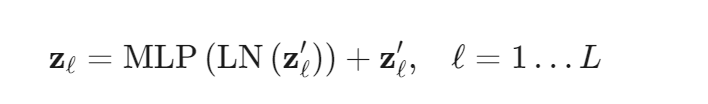)

In [ ]:
#1. Tạo lớp kế thừa nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    #2. Chỉnh tham số tương tự bảng 1
    def __init__(self,embedding_dim:int=768,# Hidden size D from Table 1 for ViT-Base
                 num_head:int=12,# Heads from Table 1 for ViT-Base
                 attn_dropout:float=0):
        super().__init__()
        #3.Tạo lớp LN
        self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
        #4. Tạo lớp MSA
        self.multihead_attn=nn.MultiheadAttention(embed_dim=embedding_dim,num_heads=num_head,dropout=attn_dropout,batch_first=True)
    def forward(self,x):
        x=self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False)
        return attn_output

In [ ]:
# Kiểm thử lớp
multihead_self_attention_block=MultiheadSelfAttentionBlock(embedding_dim=768,num_head=12)
patched_image_through_msa_block=multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


# Công thức 3: Lớp MLP ( Multilayer Perceptron)
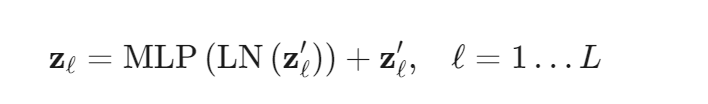

In [ ]:
#1. Tạo lớp
class MLPBlock(nn.Module):
    def __init__(self,embedding_dim:int=768 # Hidden Size D from Table 1 for ViT-Base
                 ,mlp_size:int=3072 # MLP size from Table 1 for ViT-Base
                 ,drop_out:float=0.1): # Dropout from Table 3 for ViT-Base)
        super().__init__()
        #3. Tạo lớp LN
        self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
        #4. Tạo lớp MLP
        self.mlp=nn.Sequential(nn.Linear(in_features=embedding_dim,out_features=mlp_size),
                               nn.GELU(),
                               nn.Dropout(p=drop_out),
                               nn.Linear(in_features=mlp_size,out_features=embedding_dim),
                               nn.Dropout(p=drop_out))

    def forward(self,x):
        x=self.layer_norm(x)
        x=self.mlp(x)
        return x


In [ ]:
# Kiểm thử
mlp_block=MLPBlock(embedding_dim=768,mlp_size=3072,drop_out=0.1)
patched_image_through_mlp_block=mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


# Tạo Transformer Encoder

In [ ]:
#1. Tạo một lớp có tên TransformerEncoderBlock kế thừa từ torch.nn.Module.
class TransformerEncoderBlock(nn.Module):
    #2. Khởi tạo lớp với các tham số siêu từ Bảng 1 và Bảng 3 của bài báo ViT cho mô hình ViT-Base.
    def __init__(self,embedding_dim:int=768,num_heads:int=12,mlp_size:int=3072,mlp_dropout:float=0.1,attn_dropout:float=0):
        super().__init__()
        #3. Khởi tạo một khối MSA
        self.msa_block=MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,num_head=num_heads,attn_dropout=attn_dropout)
        #4.Khởi tạo một khối MLP
        self.mlp_block=MLPBlock(embedding_dim=embedding_dim,mlp_size=mlp_size,drop_out=mlp_dropout)

    #5. Tạo 1 phương thức forward
    def forward(self,x):
        #6. Tạo kết nối bỏ qua cho khối MSA Block(Thêm Input vào output)
        x=self.msa_block(x)+x
        #7. Tạo kết nối bỏ qua cho khối MLP(Thêm Input vào output)
        x=self.mlp_block(x)+x
        return x

In [ ]:
# Kiểm thử
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, drop_out=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [ ]:
# xem Transformer Encoder sau khi gộp MSA và MLP
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
col_names=["input_size", "output_size", "num_params", "trainable"],
col_width=20,
row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
# Tạo Transformer Encoder với Pytorch's Transformer Layers
torch_transformer_encoder_layer=nn.TransformerEncoderLayer(d_model=768 # Kích thước ẩn D từ bảng 1 ViT-Base
                                                           ,nhead=12 # Số đầu từ bảng 1 ViT-Base
                                                           ,dim_feedforward=3072 # Kích thước MLP
                                                           ,dropout=0.1# Lượng DropOut của các lớp dày đặc từ Bảng 3 mô hình ViT-Base
                                                           ,activation="gelu" # Hàm kích hoạt phi tuyến tính GeLU
                                                           ,batch_first=True #Dùng Batch_first
                                                           ,norm_first=True)# Chuẩn hoá sau mỗi MSA và MLP

In [ ]:
# Kiến trúc mô hình
summary(model=torch_transformer_encoder_layer,
input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
col_names=["input_size", "output_size", "num_params", "trainable"],
col_width=20,
row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# Tổng kết: Kết hợp tất cả các lớp lại với nhau tạo ViT Model

In [ ]:
#1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    def __init__(self,img_size:int=224,in_channels:int=3,patch_size:int=16,num_transformer_layers:int=12,embedding_dim:int=768,mlp_size:int=3072,num_heads:int=12,attn_dropout:float=0,mlp_dropout:float=0.1, embedding_dropout:float=0.1,num_classes:int=1000):
        super().__init__()
        #3. Make the image size is divisible by patch size
        assert img_size%patch_size==0, f"Image size must be divisible by patch size. Image size: {img_size}, Patch size: {patch_size}"
        # 4. Calculate the number of patches (height*width/patch^2)
        self.num_patches=(img_size*img_size)//(patch_size*patch_size)
        #5. Create learnable class embeddings
        self.class_embedding=nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)
        # 6.Create learnable position embedding
        self.position_embedding=nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
        #7.Create embedding dropput values
        self.embedding_dropout=nn.Dropout(p=embedding_dropout)
        #8. Create patch embedding layer
        self.patch_embedding=PatchEmbedding(in_channel=in_channels,patch_size=patch_size,embedding_dim=embedding_dim)
        #9. Create Transformer Encoder blocks
        self.transformer_encoder=nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes))
    def forward(self,x):
        # 12. Get batch size
        batch_size=x.shape[0]
        #13. Create class token embedding and expand it to match the batchsize
        class_token=self.class_embedding.expand(batch_size,-1,-1)
        #14. Create patch embedding (Eq1)
        x=self.patch_embedding(x)
        #15. Concatenate class embedding and patch embedding (Eq1)
        x=torch.cat((class_token,x),dim=1)
        #16. Add position embedding to patch embedding(Eq1)
        x=self.position_embedding+x
        #17. Run embedding dropout (Appendix B1)
        x=self.embedding_dropout(x)
        #18. Pass patch,position and class embedding through transformer encoding
        x=self.transformer_encoder(x)
        #19. Put 0 index logts through classfier (Eq4)
        x=self.classifier(x[:,0])
        return x

In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnab

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [ ]:
# Xem kiến trúc mô hình
from torchinfo import summary
vit = ViT()
summary(model=vit,
  input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
  col_names=["input_size", "output_size", "num_params", "trainable"],
  col_width=20,
  row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 1000]           152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

# Train Model

In [ ]:
# Tạo Optimizers
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR từ bảng 3 cho ImageNet-1k
                             betas=(0.9, 0.999),
                             weight_decay=0.3)


In [ ]:
# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Thiết lập EarlyStopping
import numpy as np
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
            print('improvement!')
        else:
            self.num_bad_epochs += 1
            print(f'no improvement, bad_epochs counter: {self.num_bad_epochs}')

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)


In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from typing import List,Tuple,Dict

def train_step(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizers:torch.optim.Optimizer):
    wandb.watch(model, log_freq=100)
    model.train()
    train_acc,train_loss=0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y=X.to(devices),y.to(devices)
        y_pred=model(X)
        loss=loss_fn(y_pred,y)
        train_loss+=loss.item()
        optimizers.zero_grad()
        loss.backward()
        optimizers.step()
        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc +=(y_pred_class==y).sum().item()/len(y_pred)
    train_acc/=len(dataloader)
    train_loss/=len(dataloader)
    return train_acc,train_loss

def test_step(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module):
    model.eval()
    test_loss_values,test_acc_values=0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y=X.to(devices),y.to(devices)
            y_test_pred_logits=model(X)

            test_loss=loss_fn(y_test_pred_logits,y)
            test_loss_values+=test_loss.item()

            y_pred_class=torch.argmax(y_test_pred_logits,dim=1)
            test_acc_values += ((y_pred_class==y).sum().item()/len(y_test_pred_logits))
        test_loss_values/=len(dataloader)
        test_acc_values/=len(dataloader)
    return test_loss_values,test_acc_values
run=wandb.init(project="Vision Transformer Plane Classification Model")
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module = nn.CrossEntropyLoss(), epochs: int = 100, early_stopping=None):
    result = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_acc, train_loss = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizers=optimizer)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        result["train_loss"].append(train_loss)
        result["train_acc"].append(train_acc)
        result["test_loss"].append(test_loss)
        result["test_acc"].append(test_acc)
        wandb.log({"Train Loss": train_loss,
                   "Test Loss": test_loss,
                   "Train Accuracy": train_acc,
                   "Test Accuracy": test_acc,"Epoch":epoch})
        # Check for early stopping
        if early_stopping is not None:
            if early_stopping.step(test_loss):  # You can use any monitored metric here
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    return result

In [ ]:
#  Fit Model
early_stopping = EarlyStopping(mode='min', patience=10)
devices="cuda" if torch.cuda.is_available() else "cpu"
model_result=train(model=vit,train_dataloader=train_dataloaders,test_dataloader=test_dataloader,optimizer=optimizer,loss_fn=loss_fn,epochs=60,early_stopping=early_stopping)
run.finish() #finish wandb

In [ ]:
# hàm save model
import torch
from pathlib import Path

def save_model(model:torch.nn.Module,target_dir:str,model_name:str):
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

      # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
                 f=model_save_path)

In [ ]:
save_model(model=vit,
              target_dir="models",
              model_name="ViT_for_Classification.pt")


# So sánh kết quả với bài báo
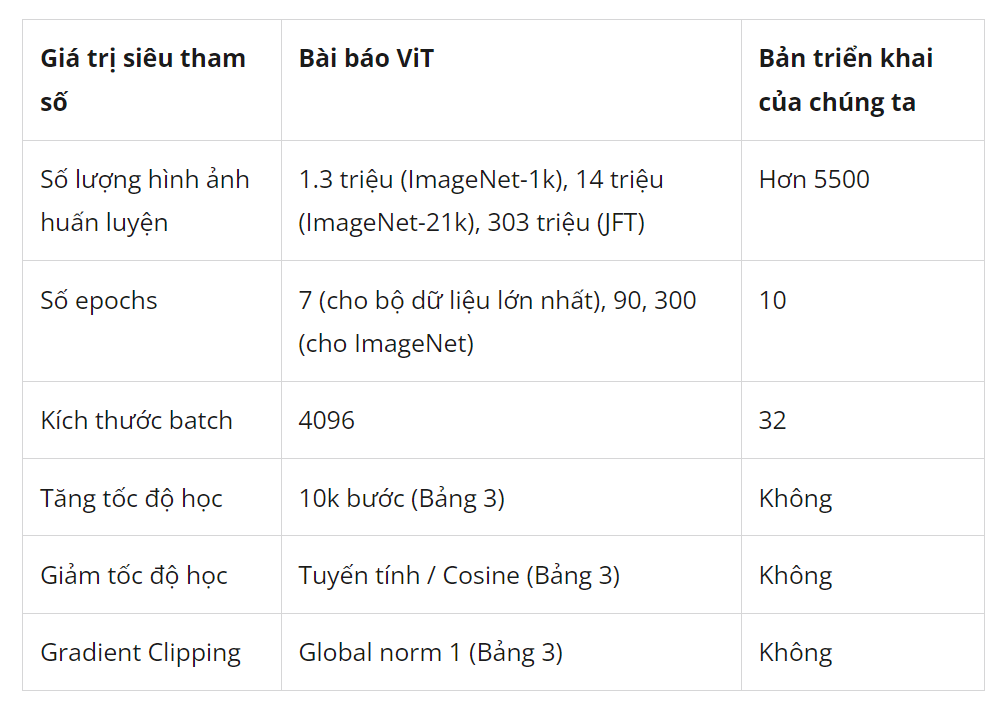
# End !!!